# COGS 108 - EDA Checkpoint

# Names

- Nhan Quach
- Joseph Morales
- Victor Wang
- Kevin Hu
- Areen Lu

<a id='research_question'></a>
# Research Question

*Fill in your research question here*

# Setup

In [8]:
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

#import stat models
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Cleaning

Describe your data cleaning steps here.

## Profane Words Data

In [ ]:
import csv

# Define a dictionary containing all relevant profane words to find
search_words = {'bastard': 0, 'bitch': 0, 'crap': 0, 'cunt': 0, 'damn': 0, 'fuck': 0, 'shit': 0, 'total': 0}

filename = "input_file.txt"

# Open the file for reading
with open(filename, "r") as file:
    # Loop through each line in the file
    for line in file:
        # Loop through each word in the dictionary
        for word in search_words:
            # Count the number of occurrences, including word substrings, in each line
            count = line.count(word)
            # If count is greater than zero, increment count for the word
            if count > 0:
                search_words[word] += count

# Sum all the values in the dictionary and add them to the 'total' key
search_words['total'] = sum(search_words.values())

# Drop the ".txt" extension from the input file name
file_basename = filename.split('.')[0]

# Write the contents of the dictionary to a CSV file
with open('search_words.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers to the first row of the CSV file
    headers = ['id'] + list(search_words.keys())
    writer.writerow(headers)
    # Write the values to the CSV file
    values = [file_basename] + list(search_words.values())
    writer.writerow(values)

The code above is used to search for profane words in a script file. The words to search for are stored in a dictionary called 'search_words'. In the script file, the code iterates through each line and counts all instances of the word or words as substrings. The count is incremented after each line. After reaching the end of the file, the total number of profane words is counted up and stored in the total key in the dictionary. The contents of the dictionary are written to a CSV file, where the first column is the ID of the script file without the '.txt' extension, and the remaining columns are the profane words and total count.

**Note:** Words such as 'ass', 'dick', 'pussy', and others were omitted as they could potentially result in false counts. For example, when looking for 'ass', words such as 'assumption', 'assign', 'class', and others would be counted although they are not profane words. Another example is 'pussy', where words like 'pussyfoot' would be counted despite not being used as profanity in a given context.

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## Profane Words Data

In [16]:
df = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
df.head()

,id,bastard,bitch,crap,cunt,damn,fuck,shit,total
0,377062,2,1,2,0,6,1,30,42
1,1189340,1,10,0,0,7,4,18,40
2,120828,0,3,1,0,3,1,13,21
3,338013,0,1,5,0,7,30,18,61
4,460989,28,1,1,1,1,46,8,86


The data presented counts the number of profane words in each movie (represented by id) script. Each column counts the specified word and any words that contain the word as a substring. For example, words such as 'motherf-ker', 'f-ker', 'f-king', and 'f-k' would all be counted the same column.

In [38]:
column_sums = df.iloc[:, 1:-1].sum()
print(column_sums)

bastard     2151
bitch       6914
crap        2338
cunt         612
damn       12955
fuck       61301
shit       31998
dtype: int64


By counting the total number of words it each column, it is evident that the most commonly used words are 'sh-t', 'f-k', and 'd-mn'. The usage of these three words are approximately 10 times more frequent than other words on the list.

Text(0.5, 1.0, 'Frequency of Profane Words')

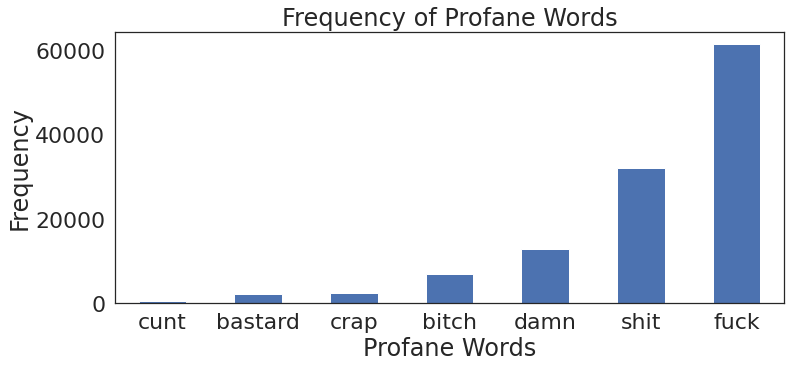

In [64]:
column_sums_sorted = column_sums.sort_values(ascending=True)
plt = column_sums_sorted.plot(kind='bar', rot=0)
plt.set_xlabel('Profane Words')
plt.set_ylabel('Frequency')
plt.set_title('Frequency of Profane Words')

From this chart, it is evident that the word 'f-k' is the the most frequently used word. The usage of this word is greater than the second and third words combined.

Text(0.5, 1.0, 'Most Used Word vs Total Words')

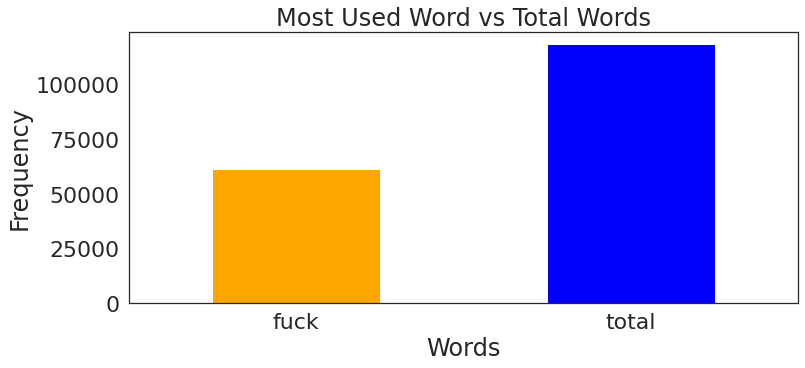

In [65]:
f_word_count = df['fuck'].sum()
total_word_count = df['total'].sum()

quantities = pd.Series([f_word_count, total_word_count], index=['fuck', 'total'])

colors = ['orange', 'blue']
plt = quantities.plot(kind='bar', color=colors,  rot = 0)

plt.set_xlabel('Words')
plt.set_ylabel('Frequency')
plt.set_title('Most Used Word vs Total Words')

Comparing the total count of all profane words to the the total count of 'f-k', it can be seen how frequently this word appears. It accounts for approximately 60% of all profane words used.

In [4]:
dfWords  = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
dfMeta = pd.read_csv("cleaned_data/cleaned_metadata_2023-03-10_20-36-27.csv")
dfMeta = dfMeta.rename(columns={"imdbId":"id"})
dfMeta["id"] = pd.to_numeric(dfMeta["id"])
dfWords["id"] = pd.to_numeric(dfWords["id"])
dfTotal = pd.merge(dfMeta,dfWords, on = "id")

In [ ]:
swearCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['total'])
sns.lineplot(data = swearCountsMean, x = "release_date", y = "total")

In [ ]:
ratingsCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['rating'])
sns.lineplot(data = ratingsCountsMean, x = "release_date", y = "rating")

In [ ]:
boxCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['revenue'])
sns.lineplot(data = boxCountsMean, x = "release_date", y = "revenue")

In [32]:
dfTotal['normTotal'] = dfTotal['total']/dfTotal['script_size']
dfPredict = dfTotal.drop([254])

In [33]:
profanePrecentMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['normTotal'])
sns.lineplot(data = profanePrecentMean, x = "release_date", y = "normTotal")

ValueError: Could not interpret value `revenue` for parameter `y`

In [9]:
regr = svm.SVR()
regr.fit(dfPredict['rating'].values.reshape(-1,1),dfPredict['normTotal'].values.reshape(-1,1))
regr.predict([[0.000113]])

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.00924813])

In [27]:
dfTotal

,adult,genres,release_date,revenue,title,id,rating,review_count,script_size,has_script,mpaa_rating,bastard,bitch,crap,cunt,damn,fuck,shit,total,normTotal
0,False,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",1997,3.395661e+07,The Relic,120004,2.815600,2359,25617.0,True,R,0,1,1,0,8,11,13,34,0.001327
1,False,"[{'id': 18, 'name': 'Drama'}]",1997,3.028094e+06,Dangerous Ground,118927,2.640086,232,17787.0,True,R,3,2,0,0,11,58,24,98,0.005510
2,False,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1997,2.154540e+06,Shadow Conspiracy,120107,2.773481,362,20253.0,True,R,2,2,1,0,7,9,6,27,0.001333
3,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,1.179002e+06,Nightwatch,119791,3.100465,861,15670.0,True,R,1,1,0,0,5,19,11,37,0.002361
4,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,2.580471e+07,Murder at 1600,119731,3.084111,3216,18696.0,True,R,0,2,0,0,2,2,9,15,0.000802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,False,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",2017,2.323802e+08,Alien: Covenant,2316204,3.054054,333,20518.0,True,R,0,1,1,0,4,42,18,66,0.003217
2940,False,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",2017,4.077780e+08,The Mummy,2345759,2.630252,119,15929.0,True,PG-13,1,2,0,0,2,0,1,6,0.000377
2941,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",2017,1.238765e+09,The Fate of the Furious,4630562,3.172764,246,26023.0,True,PG-13,0,5,0,0,12,1,20,38,0.001460
2942,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",2017,2.245113e+08,Baby Driver,3890160,3.973244,299,25248.0,True,R,0,5,0,0,14,67,30,116,0.004594


In [30]:
x = dfPredict['normTotal']
y = dfPredict['rating']
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.189
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0742
Time:                        13:54:52   Log-Likelihood:                -1815.3
No. Observations:                2943   AIC:                             3635.
Df Residuals:                    2941   BIC:                             3647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2032      0.010    310.072      0.0

eval_env: 1


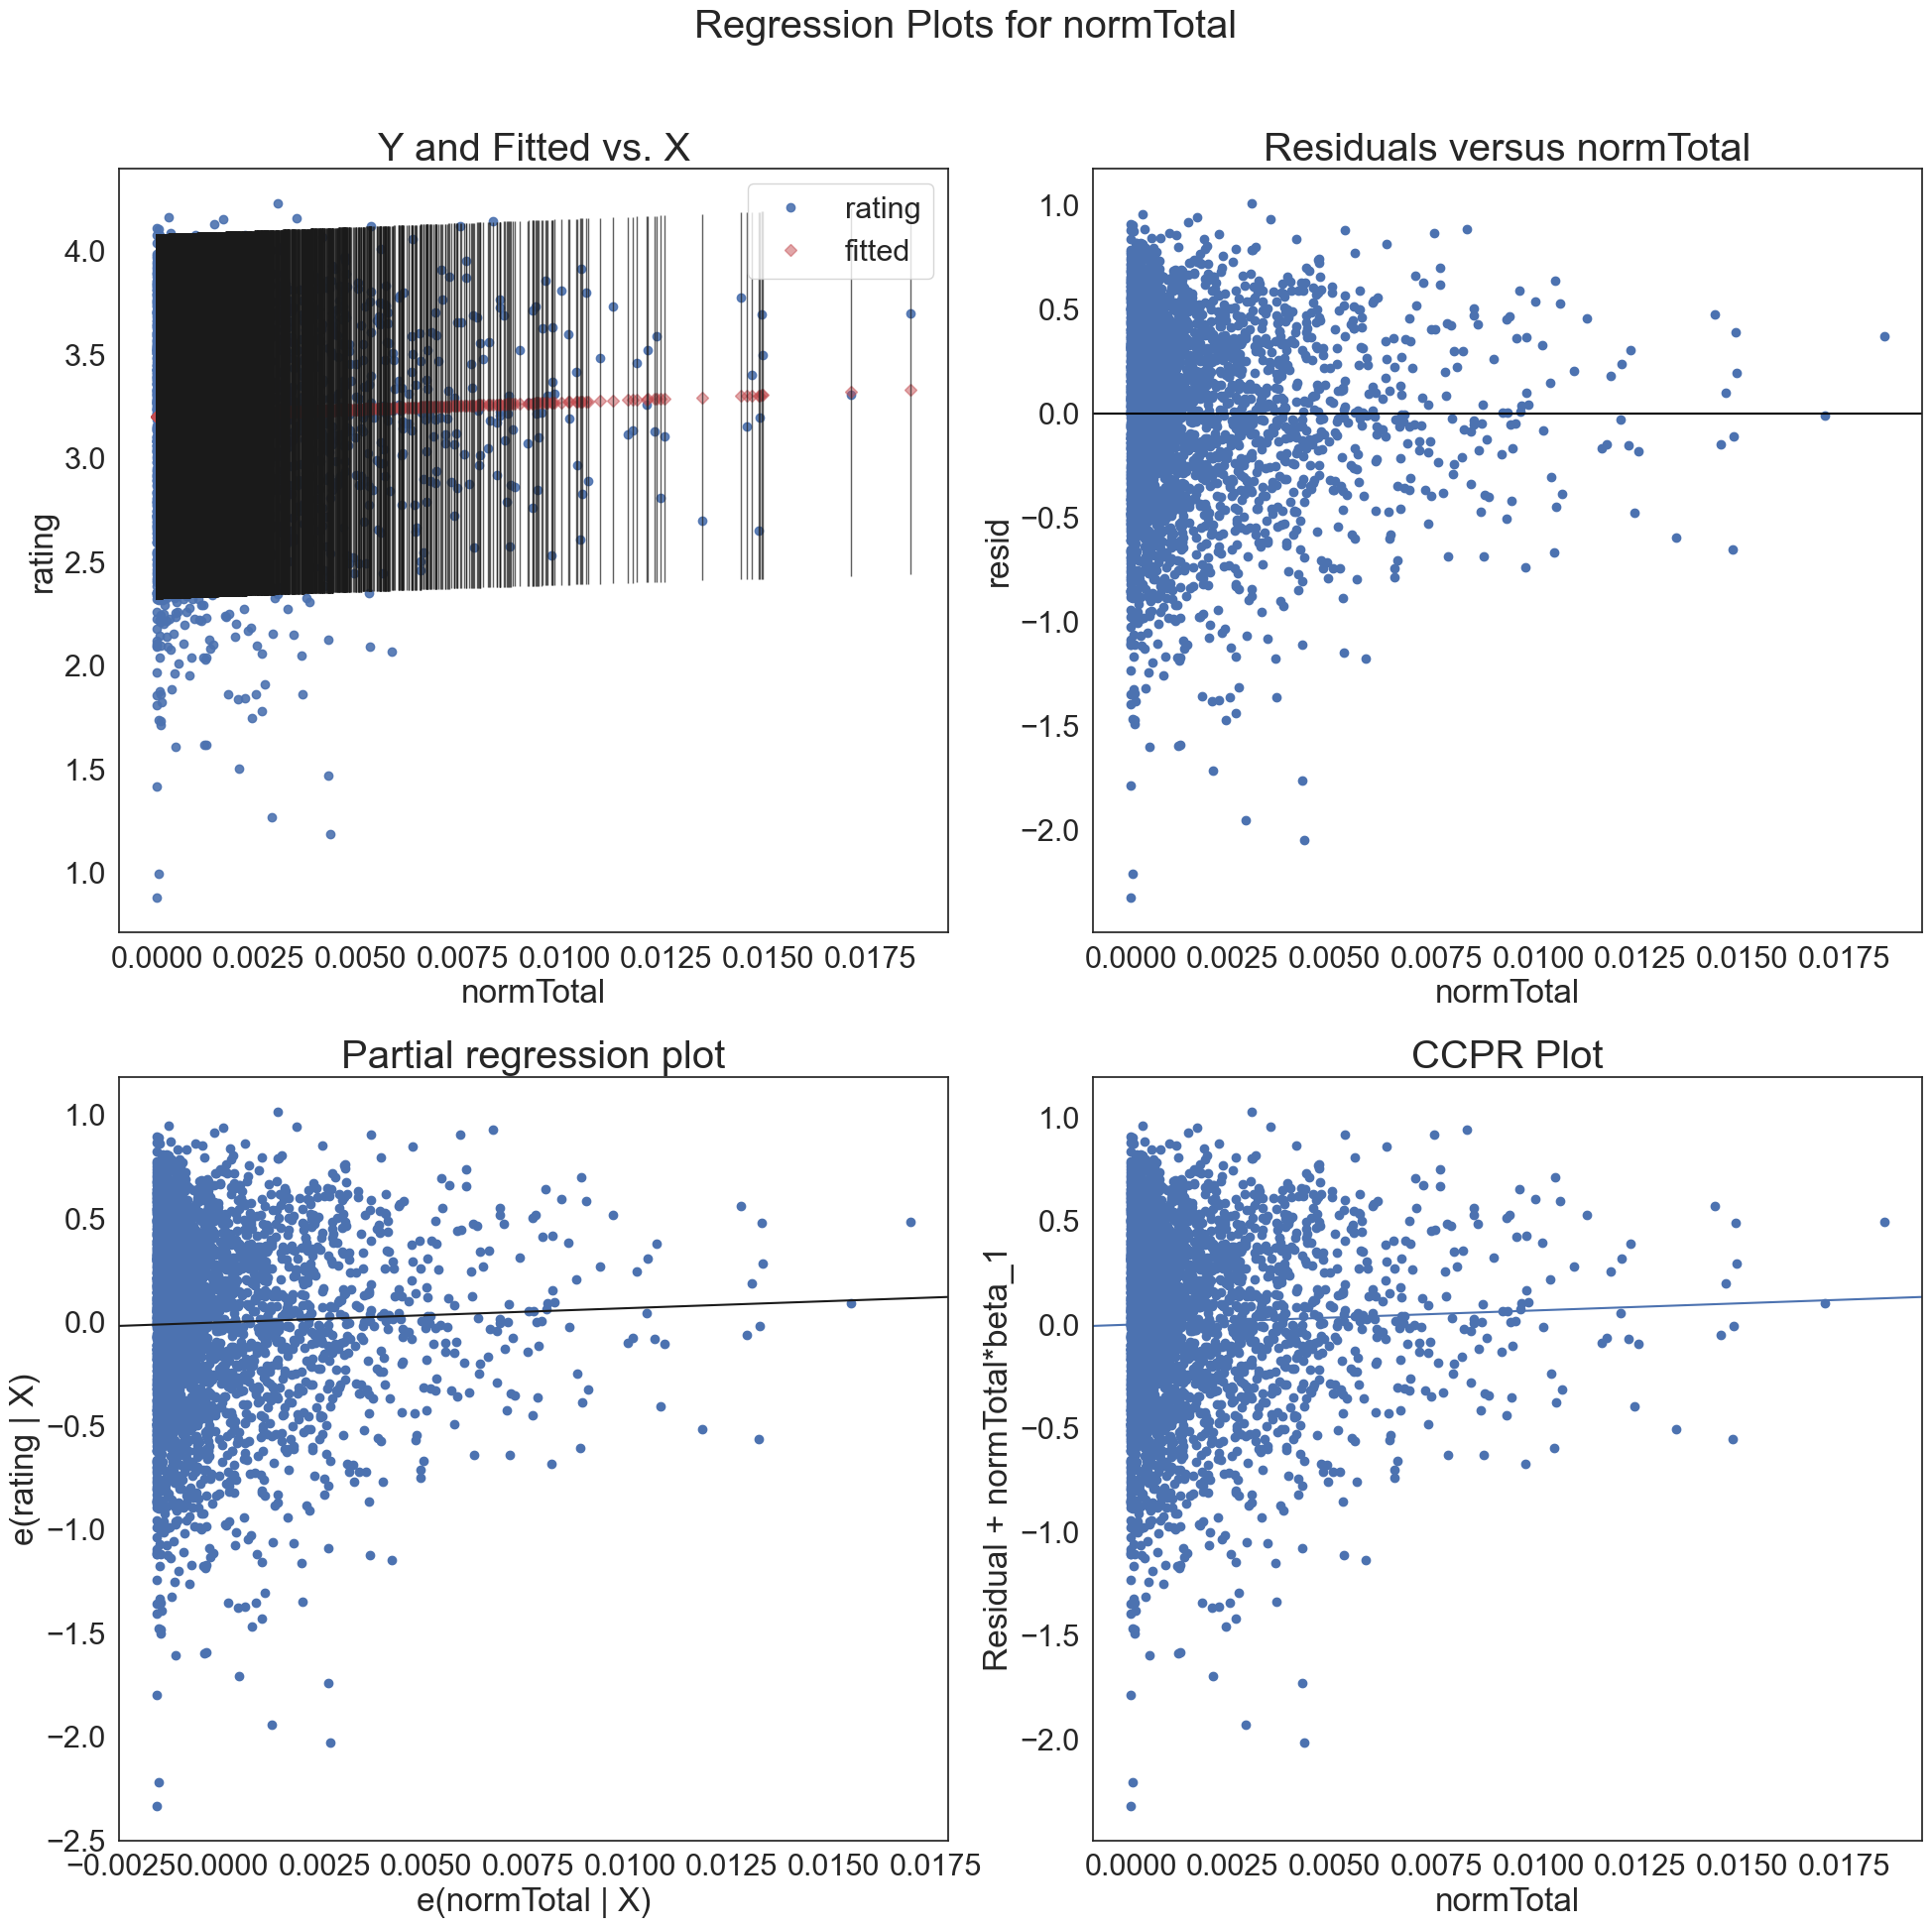

In [26]:
fig = plt.figure(figsize=(20,20))
fig = sm.graphics.plot_regress_exog(model,'normTotal',fig=fig)

In [15]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X = sm.add_constant(X)
    result = sm.OLS(Y, X).fit()
    return result.params

dfPredict.groupby('release_date').apply(regress, 'rating', 'normTotal')

,const,normTotal
release_date,,
1997,3.080352,34.855770
1998,3.134566,43.987304
1999,3.138037,27.293525
2000,3.061363,48.777469
2001,3.142206,-21.986176
2002,3.161418,-17.157831
2003,3.141400,-7.598073
2004,3.073407,58.820966
2005,3.187965,0.268549
